In [6]:
import os
import torch
from packages.utils.function_library import load_config, model_initializer
from torch.utils.data import DataLoader
from packages.data import LorenzDataSet

In [7]:
tuning_title = "test1"
CONFIG_PATH = f"packages/configs/{tuning_title}.yaml"
config = load_config(CONFIG_PATH)

# Define absolute paths to data sets
training_dir = os.path.abspath("packages/data/training_data")
testing_dir = os.path.abspath("packages/data/test_data")

# Create training and validation sets for training 
training_dataset = LorenzDataSet(training_dir, config)
testing_dataset = LorenzDataSet(testing_dir, 
                                config,
                                scalar_dict=training_dataset.scalar_dict)

# Create dataloaders for testing
testing_loader = DataLoader(testing_dataset, batch_size=config["batch_size"])

Parsing dataset: 100%|██████████| 300/300 [00:03<00:00, 98.94it/s] 


In [8]:
from packages.networks import base_model
dict_name = f"{tuning_title}.pth"

dict_file = os.path.join("packages/tuning", tuning_title, dict_name)

# Check to see if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mask = torch.ones(config["block_size"], config["block_size"], requires_grad=False).tril().to(device)
#Create model, optimizer and loss function
model = model_initializer(config, mask)
model = model.to(device)
model.load_state_dict(torch.load("packages/tuning/test1/test1.pth"))

<All keys matched successfully>

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt


sim_length = int(config["t_test"] * 100)
CL = config["block_size"]
seq_count = sim_length - CL
sim_num = 100

true = testing_dataset.raw_data[:, :, sim_num]
preds = torch.zeros_like(torch.from_numpy(true))
sequences = testing_dataset.features[seq_count*sim_num:seq_count*sim_num+seq_count, :, :]


for i in range(sequences.shape[0]):
    pred = model(torch.from_numpy(sequences[i, :, :])[None, :, :].float())
    preds[:, i+1:i+1+CL] = pred[0, :, :].T


preds = preds.detach().numpy()
    


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(true[0, 1:], true[1, 1:], true[2, 1:], alpha=0.25)
ax.scatter(preds[0, 1:], preds[1, 1:], preds[2, 1:], marker='+', c='red', s=5)

# ax.set_title("Ground Truth")

# ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax.scatter(preds[0, 1:], preds[1, 1:], preds[2, 1:])
# ax.set_title("Physformer")

In [22]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\jacob\Downloads\concentration-rfile.out.csv", index_col=0)
df

,Concentration,Flow time
Time Step,,
0,0.000000,0.0000
1,0.000000,0.0001
2,0.000000,0.0002
3,0.000000,0.0003
4,0.000000,0.0004
...,...,...
3997,0.000021,0.3997
3998,0.000021,0.3998
3999,0.000021,0.3999


In [23]:
from scipy.integrate import simpson

integrand = simpson(df['Concentration'], df['Flow time'])
E_t = df["Concentration"]/integrand
print(E_t)
tE_t = df['Flow time']*E_t

mean_RT = simpson(tE_t, df['Flow time'])
print(mean_RT)

Time Step
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
3997    0.220995
3998    0.219947
3999    0.218900
4000    0.217853
4001    0.216805
Name: Concentration, Length: 4002, dtype: float64
0.17468163714962


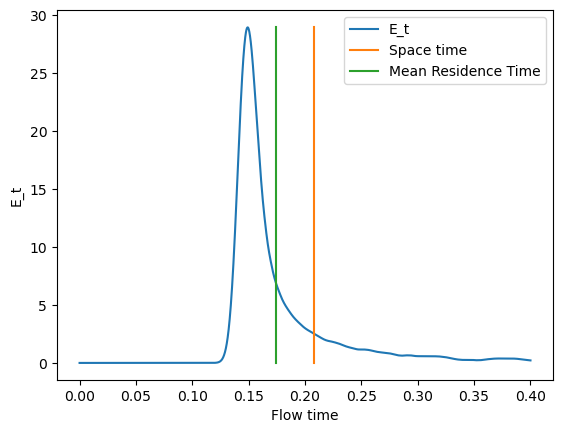

In [29]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(df['Flow time'], E_t, label='E_t')
plt.plot([0.2083, 0.2083], [0, 29], label='Space time')
plt.plot([mean_RT, mean_RT], [0, 29], label='Mean Residence Time')
plt.xlabel('Flow time')
plt.ylabel('E_t')
plt.legend()
plt.show()
